# Flutter of Binary Aeroelastic Model

***

Aerodynamic model assumption: quasi-steady aerodynamics.

![Two-dimensional airfoil.](resources/two-dimensional-airfoil.png)

Structural modes assumption: uncoupled bending and torsion modes.

![Binary aeroelastic model showing bending and torsion modes.](resources/binary-aeroelastic-model.png)

Aeroelastic equations of motion:

$$
m\left[\begin{array}{cc}
\frac{s c}{5} & \frac{s}{4}\left(\frac{c^2}{2}-c x_{\mathrm{f}}\right) \\
\frac{s}{4}\left(\frac{c^2}{2}-c x_{\mathrm{f}}\right) & \frac{s}{3}\left(\frac{c^3}{3}-c^2 x_{\mathrm{f}}+c x_{\mathrm{f}}^2\right)
\end{array}\right]\left\{\begin{array}{l}
\ddot{q}_b \\
\ddot{q}_t
\end{array}\right\}+\rho V\left[\begin{array}{cc}
\frac{c s}{10} a_{\mathrm{W}} & 0 \\
-\frac{c^2 s}{8} e a_{\mathrm{W}} & -\frac{c^3 s}{24} M_\theta
\end{array}\right]\left\{\begin{array}{l}
\dot{q}_b \\
\dot{q}_t
\end{array}\right\} 
+\left\{\rho V^2\left[\begin{array}{cc}
0 & \frac{c s}{8} a_{\mathrm{W}} \\
0 & -\frac{c^2 s}{6} e a_{\mathrm{W}}
\end{array}\right]+\left[\begin{array}{cc}
\frac{4 E I}{s^3} & 0 \\
0 & \frac{G J}{s}
\end{array}\right]\right\}\left\{\begin{array}{l}
q_b \\
q_t
\end{array}\right\}=\left\{\begin{array}{l}
0 \\
0
\end{array}\right\}
$$

General form of the aeroelastic equations:

$$
\mathbf{A} \ddot{\boldsymbol{q}}+(\rho V \mathbf{B}+\mathbf{D}) \dot{\boldsymbol{q}}+\left(\rho V^2 \mathbf{C}+\mathbf{E}\right) \boldsymbol{q}=\boldsymbol{0}
$$

Eigenvalue (flutter) solution of the aeroelastic equations:

$$
\left[\begin{array}{ll}
\mathbf{I} & 0 \\
0 & \mathbf{A}
\end{array}\right]\left\{\begin{array}{c}
\dot{q} \\
\ddot{q}
\end{array}\right\}-\left[\begin{array}{cc}
0 & \mathbf{I} \\
-\left(\rho V^2 \mathbf{C}+\mathbf{E}\right) & -(\rho V \mathbf{B}+\mathbf{D})
\end{array}\right]\left\{\begin{array}{l}
q \\
\dot{q}
\end{array}\right\}=\left\{\begin{array}{l}
0 \\
0
\end{array}\right\}
$$

$$
\left\{\begin{array}{l}
\dot{q} \\
\ddot{q}
\end{array}\right\}-\left[\begin{array}{cc}
0 & \mathbf{I} \\
-\mathbf{A}^{-1}\left(\rho V^2 \mathbf{C}+\mathbf{E}\right) & -\mathbf{A}^{-1}(\rho V \mathbf{B}+\mathbf{D})
\end{array}\right]\left\{\begin{array}{l}
q \\
\dot{q}
\end{array}\right\}=0
$$

$$
\dot{x}-Q x=0
$$

$$
(\mathbf{Q}-\mathbf{I} \lambda) x_0=0
$$

In [6]:
import numpy as np

s = 7.5  # semispan [m]
c = 2.  # chord [m]
x_f = .48*c  # position of elastic axis [m]
e = x_f/c - .25  # nondimensional distance of elastic axis from quarter chord
m = 200.  # mass [kg/m^2]
EI = 2e7  # bending rigidity [Nm^2]
GJ = 2e6 # torsional rigidity [Nm^2]
a_w = 2*np.pi  # lift curve slope
M_thetadot = -1.2  # non-dimensional pitch damping derivative
rho = 1.225  # air density [kg/m^3]

In [7]:
A = m*np.array([[s*c/5, s/4*(c**2/2 - c*x_f)],
                [s/4*(c**2/2 - c*x_f), s/3*(c**3/3 - c**2*x_f + c*x_f**2)]])
B = np.array([[c*s*a_w/10, 0],
              [-c**2*s*e*a_w/8, -c**3*s*M_thetadot/24]])
C = np.array([[0, c*s*a_w/8],
              [0, -c**2*s*e*a_w/6]])
E = np.array([[4*EI/s**3, 0],
              [0, GJ/s]])

In [8]:
A_inv = np.linalg.inv(A)
def Q_no_damping(V):
    return np.concatenate((np.concatenate((np.zeros((2, 2)), np.eye(2)), axis=1),
                           np.concatenate((-A_inv @ (rho*V**2*C + E), np.zeros((2, 2))), axis=1)))

In [9]:
V_array = np.arange(10, 201, .01)
natural_frequencies = []
damping_ratios = []
for V in V_array:
    eigvals = np.linalg.eigvals(Q_no_damping(V))
    natural_frequencies.append(np.sqrt(eigvals.real**2 + eigvals.imag**2))
    damping_ratios.append(-eigvals.real/natural_frequencies[-1])
natural_frequencies = np.stack(natural_frequencies, axis=0)
damping_ratios = np.stack(damping_ratios, axis=0)

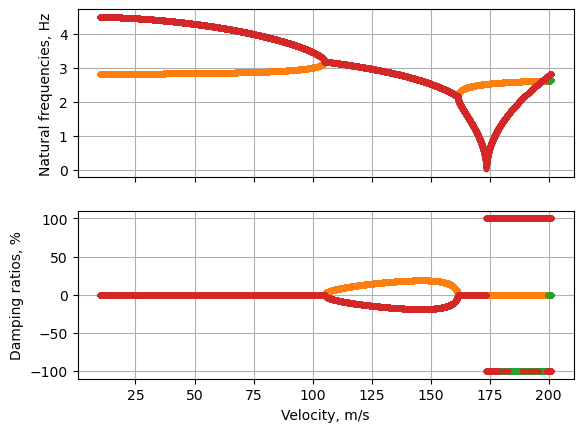

In [10]:
from matplotlib import pyplot as plt  # import the pyplot module

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(V_array, natural_frequencies/(2*np.pi), '.')
axes[0].set_ylabel('Natural frequencies, Hz')
axes[0].grid()
axes[1].plot(V_array, damping_ratios*100, '.')
axes[1].set_ylabel('Damping ratios, %')
axes[1].set_xlabel('Velocity, m/s')
axes[1].grid()
plt.show()

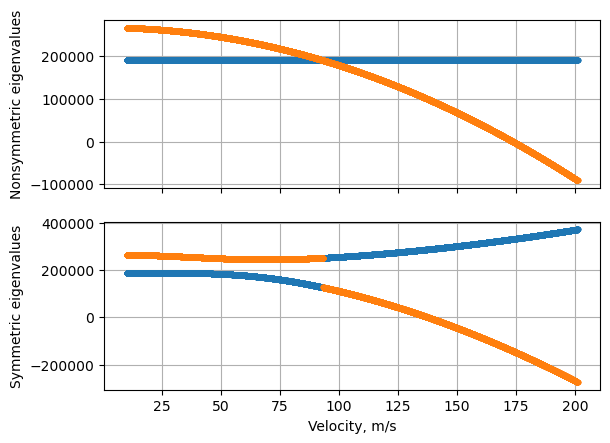

In [11]:
def K(V):
    return rho*V**2*C + E

def K_symmetric(V):
    K_ = K(V)
    return (K_ + K_.T)/2

K_eigenvalues = []
K_symmetric_eigenvalues = []
for V in V_array:
    K_eigenvalues.append(np.linalg.eigvals(K(V)))
    K_symmetric_eigenvalues.append(np.linalg.eigvals(K_symmetric(V)))
K_eigenvalues = np.stack(K_eigenvalues, axis=0)
K_symmetric_eigenvalues = np.stack(K_symmetric_eigenvalues, axis=0)

fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(V_array, K_eigenvalues.real, '.')
axes[0].set_ylabel('Nonsymmetric eigenvalues')
axes[0].grid()
axes[1].plot(V_array, K_symmetric_eigenvalues.real, '.')
axes[1].set_ylabel('Symmetric eigenvalues')
axes[1].set_xlabel('Velocity, m/s')
axes[1].grid()
plt.show()

In [12]:
# import sympy as sp

# eigval, V = sp.symbols('eigval V')
# sp.init_printing(use_unicode=True)
# matrix_polynomial = eigval**2 * sp.Matrix(A) + eigval * V * sp.Matrix(rho*B) + V**2 * sp.Matrix(rho * C) + sp.Matrix(E)
# expr = sp.solve(matrix_polynomial.det(), eigval)
# f = sp.lambdify(V, expr)
# f(100)